In [1]:
import GimnTools


from GimnTools.ImaGIMN.gimnRec.reconstructors.line_integral_reconstructor import line_integral_reconstructor
from GimnTools.ImaGIMN.gimnRec.reconstructors.system_matrix_reconstruction import reconstructor_system_matrix_cpu
from GimnTools.ImaGIMN.gimnRec.reconstructors.rotation_reconstruction import rotation_reconstructor
from GimnTools.ImaGIMN.processing.interpolators.reconstruction import beta_spline_interpolation, bilinear_interpolation, nearest_neighbor_interpolation
from GimnTools.ImaGIMN.gimnRec.reconstruction_filters import ramLak
from GimnTools.ImaGIMN.gimnRec.projectors import radon_m, projector, direct_radon



from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage.data import shepp_logan_phantom, horse
import scipy.io
import numpy as np 
from copy import deepcopy 
from pathlib import Path

from GimnTools.ImaGIMN.phantoms.random import generate_random_image


In [3]:

from GimnTools.ImaGIMN.phantoms.derenzzo import DerenzoPhantomSlice

def derenzo_phantom_test(noise_factor=0.3):
    """
    Generates a Derenzo phantom image, resizes it, and saves it as a PNG file.
    """
    import matplotlib.pyplot as plt

    # Teste do código adaptado
    radius = 29.0 / 2
    num_sections = 4
    well_counts = (6, 6, 10, 15)
    well_diameters = (2.5, 2.0, 1.5, 1.0)
    well_separations = (2.5, 2.0, 1.5, 1.0)
    section_offsets = (0.00000001, 0.01, 0.01, 0.1)  # Offset personalizado para cada seção
    circle_value = 1
    well_value = 10
    image_size = 128


    try:
        my_phantom = DerenzoPhantomSlice(radius, num_sections, well_counts, well_diameters, well_separations, section_offsets,
                                    image_size=image_size, circle_value=circle_value, well_value=well_value)

        #my_phantom.save_image('derenzo_phantom_with_offsets.png')

        # Obter a matriz da imagem contendo apenas o círculo de fundo
        circle_image_matrix = my_phantom.draw_only_circle()
        # Obter a matriz completa do fantoma
        phantom_matrix = my_phantom.get_image_matrix()

        noisy_image = np.random.poisson(phantom_matrix*noise_factor).astype(np.float64)
        
        plt.imshow (noisy_image, cmap='jet')
        plt.title('Derenzo Phantom with Noise')
        plt.colorbar()
        print(f"✅ Imagem simulada de um fantoma derenzo de raio {radius}mm e poços com diametros {well_diameters} mm  com ruído foi criada e tem dimensões: {noisy_image.shape}")
        
        #path = "./output/"
        #Path(path).mkdir(parents=True, exist_ok=True)
        #plt.savefig(path + "derenzo_phantom_test.png", bbox_inches='tight', pad_inches=0.1)
        return noisy_image
    
    except Exception as e:
        print(f"⚠️  Erro ao criar o fantoma Derenzo: {e}")
        return np.zeros((image_size, image_size))



✅ Imagem simulada de um fantoma derenzo de raio 14.5mm e poços com diametros (2.5, 2.0, 1.5, 1.0) mm  com ruído foi criada e tem dimensões: (128, 128)


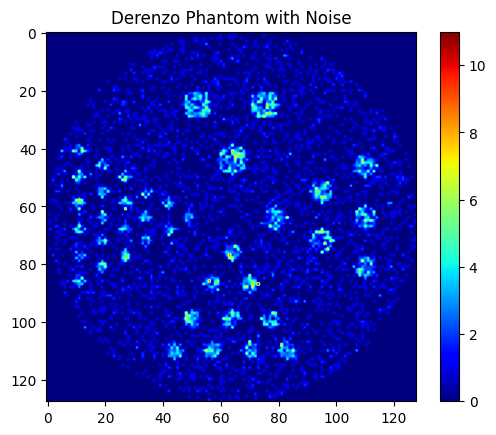

In [ ]:
data = derenzo_phantom_test(0.3)



✅ Imagem simulada de um fantoma derenzo de raio 14.5mm e poços com diametros (2.5, 2.0, 1.5, 1.0) mm  com ruído foi criada e tem dimensões: (128, 128)


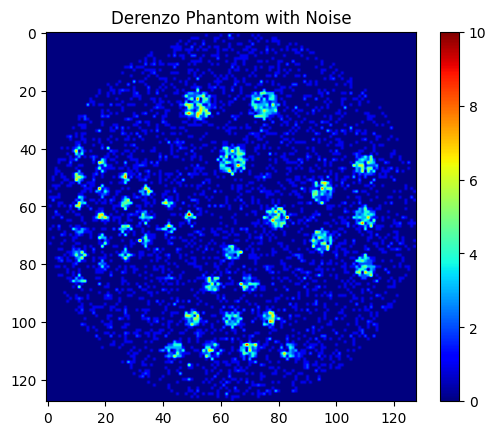

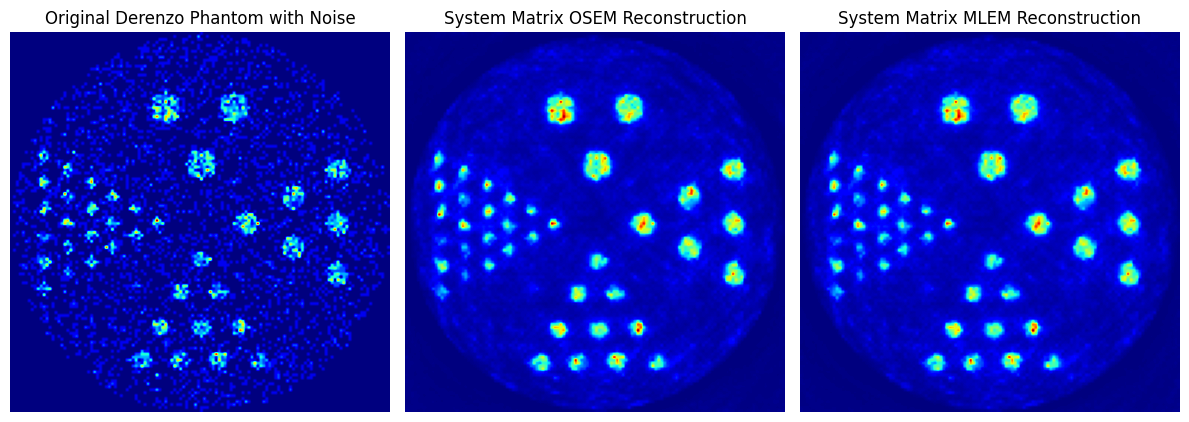

In [8]:
import matplotlib.pyplot as plt

pixels = 128  # Size of the image
number_of_angles = pixels  # Number of angles for the sinogram
number_of_slices = 2  # Number of slices in the stack

# Generate a derenzo phantom image with noise
noisy_image = derenzo_phantom_test(noise_factor=0.3)
angles = np.linspace(0, 180, number_of_angles, endpoint=True)
sinogram = direct_radon(noisy_image, angles)
stack = np.asarray([sinogram for _ in range(number_of_slices)])

# neste cara os angulos tem que ser invertidos linspace(180,0)
# Para este cara deve ser Slice/Angle/bins
angles_sm = np.linspace(180,0 , number_of_angles, endpoint=False)
stk = np.transpose(stack, (0, 2, 1)) 

iterations = 3 
subsets = 8 

reconstructor = reconstructor_system_matrix_cpu(stk)
recon_osem_sm = reconstructor.osem(iterations,subsets, angles_sm, show_images=False)
recon_mlem_sm = reconstructor.mlem(iterations*subsets, angles_sm)

cmap = 'jet'
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(noisy_image, cmap=cmap)
plt.title('Original Derenzo Phantom with Noise')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(recon_osem_sm[0], cmap=cmap)
plt.title('System Matrix OSEM Reconstruction')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(recon_mlem_sm[0], cmap=cmap) 
plt.title('System Matrix MLEM Reconstruction')
plt.axis('off')
plt.tight_layout()
